# TransKal Evaluation on New TEP Dataset

This notebook evaluates the trained TransKal model on the newly generated independent TEP dataset.

**Purpose**: Test model generalization on completely unseen data generated from `tep-sim`.

**Model**: TransKal (multiclass fault classification)

**Evaluation Dataset**: `data/new_multiclass_eval.csv` (generated by notebook 03)

## Configuration & Imports

In [1]:
import os
import json
import time
import math
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

QUICK_MODE = False
if (DATA_DIR / 'new_multiclass_eval_quick.csv').exists():
    if not (DATA_DIR / 'new_multiclass_eval.csv').exists():
        QUICK_MODE = True
    else:
        quick_mtime = (DATA_DIR / 'new_multiclass_eval_quick.csv').stat().st_mtime
        full_mtime = (DATA_DIR / 'new_multiclass_eval.csv').stat().st_mtime
        QUICK_MODE = quick_mtime > full_mtime

if os.environ.get('QUICK_MODE', '').lower() in ('true', '1', 'yes'):
    QUICK_MODE = True

FILE_SUFFIX = '_quick' if QUICK_MODE else ''

print('='*60)
print('TransKal Evaluation on New TEP Dataset')
if QUICK_MODE:
    print('QUICK MODE - Using limited test dataset')
print(f'Device: {device}')
print('='*60)

TransKal Evaluation on New TEP Dataset
Device: cuda


## Define Model Architecture

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    """Transformer classifier for time series (matches v1 architecture)."""
    def __init__(self, input_dim, num_classes, d_model=32, nhead=2, 
                 num_layers=1, dropout=0.3):
        super().__init__()
        self.d_model = d_model
        
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout)
        )
        
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, 
            dim_feedforward=d_model * 2,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.embedding(x) * np.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)

class KalmanFilter:
    """Adaptive Kalman filter for smoothing predictions within a single run."""
    def __init__(self, num_classes, Q=1e-5, R=0.1):
        self.num_classes = num_classes
        self.Q_base = Q
        self.R_base = R
        self.transition_threshold = 0.25
        self.confidence_threshold = 0.65
        self.stabilization_steps = 3
        self.vote_window = 5
        self.reset()
        
    def reset(self):
        self.x_est = None
        self.P = None
        self.steps_since_transition = 100
        self.prev_class = None
        self.prob_history = []
        
    def _compute_entropy(self, probs):
        probs = np.clip(probs, 1e-10, 1.0)
        entropy = -np.sum(probs * np.log(probs))
        max_entropy = np.log(len(probs))
        return entropy / max_entropy if max_entropy > 0 else 0
    
    def _detect_transition(self, prev_state, curr_obs, prev_class, curr_class):
        if curr_class == prev_class:
            return False
        curr_conf = np.max(curr_obs)
        prev_class_drop = prev_state[prev_class] - curr_obs[prev_class]
        prob_change = np.abs(curr_obs - prev_state).max()
        if curr_conf > self.confidence_threshold and prev_class_drop > 0.15:
            return True
        if prob_change > self.transition_threshold and curr_conf > 0.5:
            return True
        return False
        
    def update(self, observation):
        probs = np.array(observation).flatten()
        probs = np.clip(probs, 1e-10, 1.0)
        probs = probs / probs.sum()
        
        self.prob_history.append(probs.copy())
        if len(self.prob_history) > self.vote_window:
            self.prob_history.pop(0)
        
        curr_class = np.argmax(probs)
        
        if self.x_est is None:
            self.x_est = probs.copy()
            self.P = np.eye(self.num_classes) * 0.1
            self.prev_class = curr_class
            return self.x_est
        
        if self._detect_transition(self.x_est, probs, self.prev_class, curr_class):
            self.x_est = probs.copy()
            self.P = np.eye(self.num_classes) * 0.1
            self.steps_since_transition = 0
            self.prev_class = curr_class
            return self.x_est
        
        entropy = self._compute_entropy(probs)
        transition_factor = min(1.0, self.steps_since_transition / self.stabilization_steps)
        confidence = np.max(probs)
        
        Q = self.Q_base * (1 + 4 * entropy) * (2 - transition_factor)
        R = self.R_base * (1 - confidence + entropy) * transition_factor
        
        x_pred = self.x_est.copy()
        P_pred = self.P + Q * np.eye(self.num_classes)
        
        H = np.eye(self.num_classes)
        S = P_pred + R * np.eye(self.num_classes)
        K = P_pred @ np.linalg.inv(S)
        
        self.x_est = x_pred + K @ (probs - x_pred)
        self.x_est = np.clip(self.x_est, 0, 1)
        self.x_est = self.x_est / self.x_est.sum()
        
        self.P = (np.eye(self.num_classes) - K @ H) @ P_pred
        self.steps_since_transition += 1
        self.prev_class = np.argmax(self.x_est)
        
        return self.x_est

print('Model and KalmanFilter classes defined')

Model and KalmanFilter classes defined


## Load Trained Model

In [3]:
print('\n[Step 1/5] Loading trained TransKal model...')

model_path = MODEL_DIR / 'transkal_final.pt'
model_data = torch.load(model_path, map_location=device, weights_only=False)

config = model_data['model_config']
features = model_data['features']
label_classes = model_data['label_encoder_classes']
scaler_mean = model_data['scaler_mean']
scaler_scale = model_data['scaler_scale']
kalman_params = model_data['kalman_params']

num_classes = len(label_classes)
class_names = [str(int(c)) for c in label_classes]

model = TransformerClassifier(
    input_dim=config['input_dim'],
    num_classes=config['num_classes'],
    d_model=config['d_model'],
    nhead=config['nhead'],
    num_layers=config['num_layers'],
    dropout=config['dropout']
)
model.load_state_dict(model_data['model_state_dict'])
model.to(device)
model.eval()

print(f'Model loaded from {model_path}')
print(f'  Features: {len(features)}')
print(f'  Classes: {num_classes}')
print(f'  Kalman Q: {kalman_params["Q"]:.6f}')
print(f'  Kalman R: {kalman_params["R"]:.6f}')

orig_metrics_path = METRICS_DIR / 'transkal_metrics.json'
with open(orig_metrics_path) as f:
    orig_metrics = json.load(f)
print('Original metrics loaded for comparison')


[Step 1/5] Loading trained TransKal model...
Model loaded from ../outputs/models/transkal_final.pt
  Features: 52
  Classes: 18
  Kalman Q: 0.000050
  Kalman R: 0.022251
Original metrics loaded for comparison


## Load New Evaluation Dataset

In [4]:
print('\n[Step 2/5] Loading new evaluation dataset...')
start_time = time.time()

eval_file = DATA_DIR / f'new_multiclass_eval{FILE_SUFFIX}.csv'
eval_data = pd.read_csv(eval_file)

print(f'Dataset loaded in {time.time() - start_time:.2f}s')
print(f'  File: {eval_file.name}')
print(f'  Shape: {eval_data.shape}')
print(f'  Unique runs: {eval_data.groupby(["faultNumber", "simulationRun"]).ngroups}')


[Step 2/5] Loading new evaluation dataset...
Dataset loaded in 17.24s
  File: new_multiclass_eval.csv
  Shape: (1968600, 57)
  Unique runs: 2700


## Create Sequence Dataset

In [5]:
class SimulationRunDataset(Dataset):
    def __init__(self, df, features, scaler_mean, scaler_scale, label_classes, sequence_length=10):
        self.sequence_length = sequence_length
        self.features = features
        self.label_classes = label_classes
        self.class_to_idx = {c: i for i, c in enumerate(label_classes)}
        
        self.sequences = []
        self.labels = []
        self.run_indices = []  # Track which run each window belongs to
        
        run_idx = 0
        for (fault, run), group in df.groupby(['faultNumber', 'simulationRun']):
            group = group.sort_values('sample')
            X = group[features].values
            X = (X - scaler_mean) / scaler_scale
            
            for i in range(len(X) - sequence_length + 1):
                seq = X[i:i+sequence_length]
                self.sequences.append(seq)
                self.labels.append(self.class_to_idx[fault])
                self.run_indices.append(run_idx)
            run_idx += 1
        
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
        self.run_indices = np.array(self.run_indices, dtype=np.int64)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx]), torch.tensor(self.run_indices[idx])

print('Dataset class defined')

Dataset class defined


In [6]:
print('\n[Step 3/5] Creating evaluation dataset...')
seq_len = config['sequence_length']

eval_dataset = SimulationRunDataset(
    eval_data, features, scaler_mean, scaler_scale, label_classes, seq_len
)
eval_loader = DataLoader(eval_dataset, batch_size=512, shuffle=False, num_workers=0)

print(f'Evaluation sequences: {len(eval_dataset):,}')


[Step 3/5] Creating evaluation dataset...
Evaluation sequences: 1,863,300


## Generate Predictions

In [7]:
print('\n[Step 4/5] Generating predictions with Kalman filter...')
pred_start = time.time()

# Initialize Kalman filter with saved parameters
kalman = KalmanFilter(num_classes, Q=kalman_params['Q'], R=kalman_params['R'])

# Collect all predictions, labels, and run indices
all_probs = []
all_labels = []
all_run_indices = []

with torch.no_grad():
    for X_batch, y_batch, run_batch in eval_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(y_batch.numpy())
        all_run_indices.extend(run_batch.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
all_run_indices = np.array(all_run_indices)

# Apply Kalman filter per run
filtered_preds = []
current_run = -1

for i in range(len(all_probs)):
    if all_run_indices[i] != current_run:
        kalman.reset()
        current_run = all_run_indices[i]
    
    filtered_probs = kalman.update(all_probs[i])
    filtered_preds.append(np.argmax(filtered_probs))

y_pred = np.array(filtered_preds)
y_eval = all_labels

# Also compute raw predictions for comparison
y_pred_raw = np.argmax(all_probs, axis=1)

print(f'Predictions generated in {time.time() - pred_start:.2f}s')
print(f'  Predictions shape: {y_pred.shape}')
print(f'  Unique runs processed: {len(np.unique(all_run_indices))}')


[Step 4/5] Generating predictions with Kalman filter...
Predictions generated in 228.75s
  Predictions shape: (1863300,)
  Unique runs processed: 2700


## Compute Evaluation Metrics

In [8]:
print('\n[Step 5/5] Computing evaluation metrics...')

accuracy = accuracy_score(y_eval, y_pred)
balanced_acc = balanced_accuracy_score(y_eval, y_pred)
f1_weighted = f1_score(y_eval, y_pred, average='weighted')
f1_macro = f1_score(y_eval, y_pred, average='macro')
precision_weighted = precision_score(y_eval, y_pred, average='weighted')
recall_weighted = recall_score(y_eval, y_pred, average='weighted')
f1_per_class = f1_score(y_eval, y_pred, average=None)
cm = confusion_matrix(y_eval, y_pred)

# Raw metrics for comparison
accuracy_raw = accuracy_score(y_eval, y_pred_raw)
f1_weighted_raw = f1_score(y_eval, y_pred_raw, average='weighted')

print('\n' + '='*60)
print('NEW EVALUATION DATASET RESULTS (with Kalman Filter)')
if QUICK_MODE:
    print('(Quick mode - limited samples per class)')
print('='*60)
print(f'Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)')
print(f'Balanced Accuracy: {balanced_acc:.4f}')
print(f'F1 (weighted):     {f1_weighted:.4f}')
print(f'F1 (macro):        {f1_macro:.4f}')
print('='*60)
print(f'\nComparison with raw Transformer predictions:')
print(f'  Raw Accuracy: {accuracy_raw:.4f} -> With Kalman: {accuracy:.4f} ({(accuracy-accuracy_raw)*100:+.2f}%)')
print(f'  Raw F1:       {f1_weighted_raw:.4f} -> With Kalman: {f1_weighted:.4f} ({(f1_weighted-f1_weighted_raw)*100:+.2f}%)')


[Step 5/5] Computing evaluation metrics...

NEW EVALUATION DATASET RESULTS (with Kalman Filter)
Accuracy:          0.8721 (87.21%)
Balanced Accuracy: 0.8821
F1 (weighted):     0.8403
F1 (macro):        0.8543

Comparison with raw Transformer predictions:
  Raw Accuracy: 0.8721 -> With Kalman: 0.8721 (+0.00%)
  Raw F1:       0.8403 -> With Kalman: 0.8403 (-0.00%)


In [9]:
print('\nComparison with Original Test Set:')
print('-' * 50)
print(f'{"Metric":<20} {"Original":>12} {"New Eval":>12} {"Delta":>10}')
print('-' * 50)

comparisons = [
    ('Accuracy', orig_metrics['accuracy'], accuracy),
    ('Balanced Acc', orig_metrics['balanced_accuracy'], balanced_acc),
    ('F1 (weighted)', orig_metrics['f1_weighted'], f1_weighted),
    ('F1 (macro)', orig_metrics['f1_macro'], f1_macro),
]

for metric_name, orig_val, new_val in comparisons:
    delta = new_val - orig_val
    print(f'{metric_name:<20} {orig_val:>12.4f} {new_val:>12.4f} {delta:>+10.4f}')

print('-' * 50)


Comparison with Original Test Set:
--------------------------------------------------
Metric                   Original     New Eval      Delta
--------------------------------------------------
Accuracy                   0.9909       0.8721    -0.1188
Balanced Acc               0.9909       0.8821    -0.1087
F1 (weighted)              0.9909       0.8403    -0.1506
F1 (macro)                 0.9909       0.8543    -0.1366
--------------------------------------------------


In [10]:
print('\nPer-Class Classification Report:')
print(classification_report(y_eval, y_pred, target_names=class_names, digits=4))


Per-Class Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000    114300
           1     1.0000    0.9961    0.9980    114300
           2     0.9896    0.9974    0.9935    114300
           4     1.0000    0.0971    0.1770    114300
           5     0.9922    1.0000    0.9961    114300
           6     1.0000    1.0000    1.0000     11700
           7     1.0000    1.0000    1.0000    114300
           8     0.9401    0.9895    0.9642    114300
          10     0.3944    1.0000    0.5657    114300
          11     1.0000    1.0000    1.0000    114300
          12     0.8514    1.0000    0.9197    114300
          13     0.8015    0.9961    0.8882    114300
          14     1.0000    1.0000    1.0000    114300
          16     1.0000    0.9921    0.9960    114300
          17     1.0000    0.9488    0.9737    114300
          18     1.0000    0.9539    0.9764     22800
          19     1.0000    0.9777    0.9887    

## Visualizations

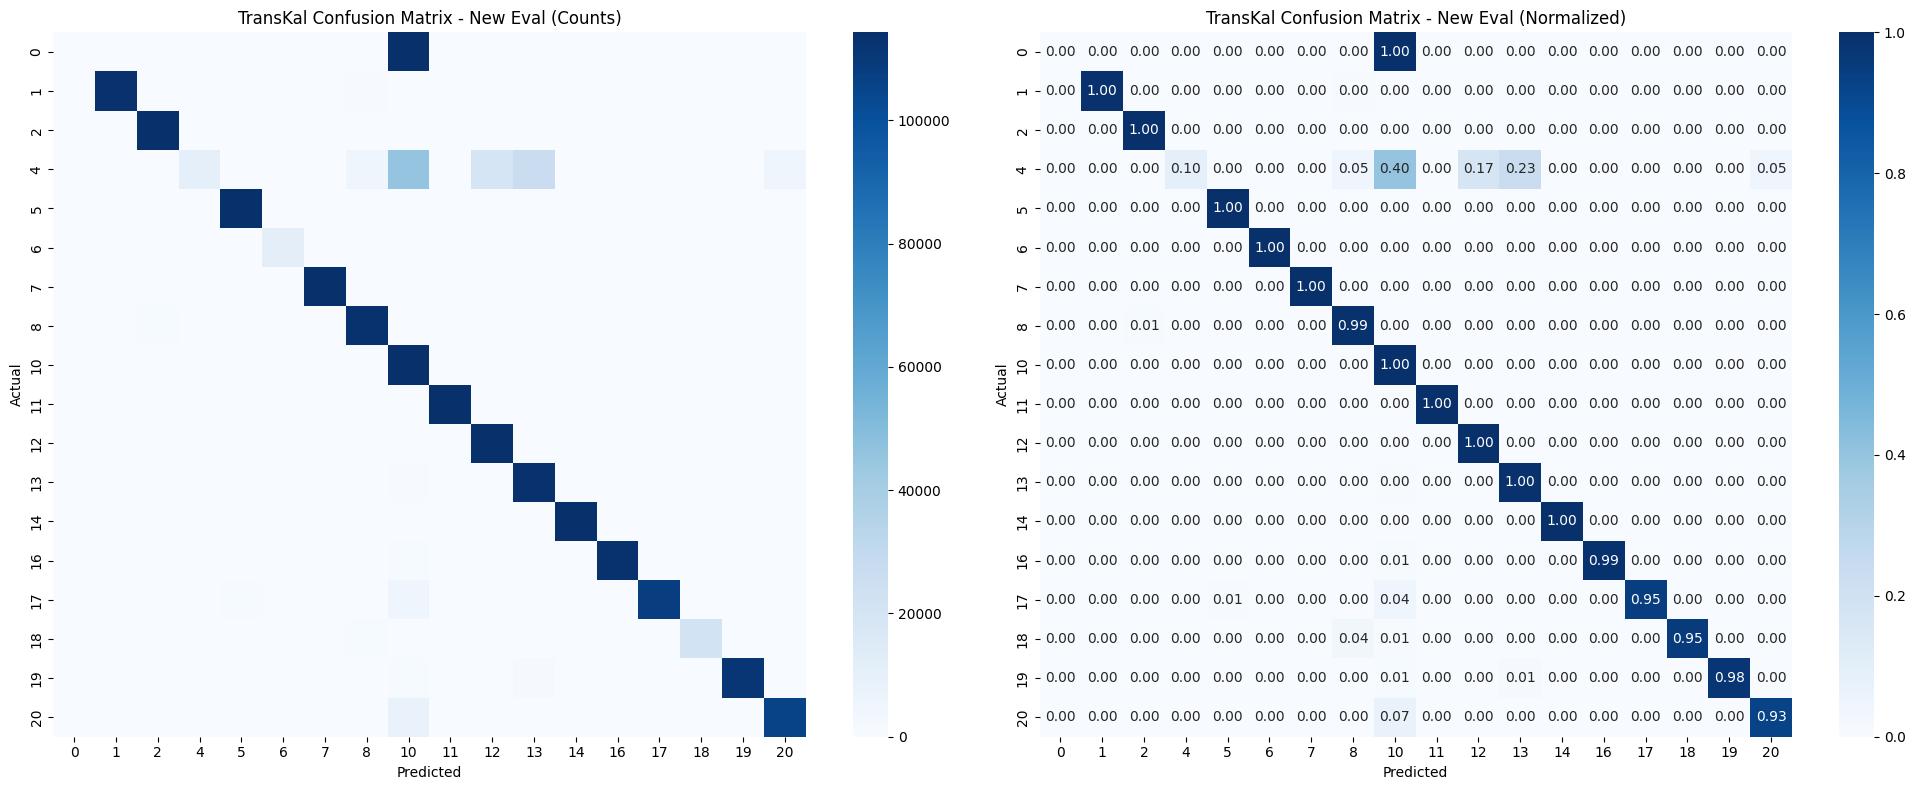

Saved to ../outputs/figures/transkal_new_eval_confusion_matrix.png


In [11]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('TransKal Confusion Matrix - New Eval (Counts)')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('TransKal Confusion Matrix - New Eval (Normalized)')

plt.tight_layout()
output_file = FIGURES_DIR / f'transkal_new_eval_confusion_matrix{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

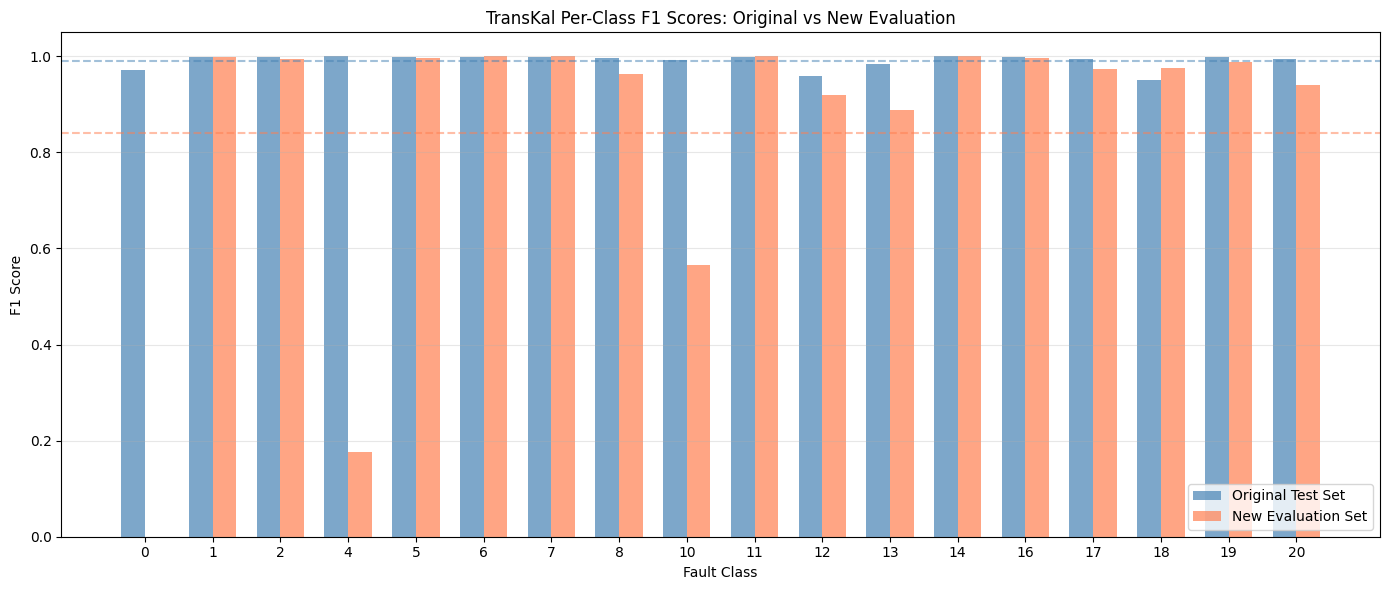

Saved to ../outputs/figures/transkal_new_eval_per_class_f1.png


In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(class_names))
width = 0.35

orig_f1_per_class = [orig_metrics['per_class_f1'][c] for c in class_names]

bars1 = ax.bar(x - width/2, orig_f1_per_class, width, label='Original Test Set', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, f1_per_class, width, label='New Evaluation Set', color='coral', alpha=0.7)

ax.axhline(y=orig_metrics['f1_weighted'], color='steelblue', linestyle='--', alpha=0.5)
ax.axhline(y=f1_weighted, color='coral', linestyle='--', alpha=0.5)

ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Score')
ax.set_title('TransKal Per-Class F1 Scores: Original vs New Evaluation')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
output_file = FIGURES_DIR / f'transkal_new_eval_per_class_f1{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

## Save Results

In [13]:
new_eval_metrics = {
    'model': 'TransKal',
    'dataset': f'new_multiclass_eval{FILE_SUFFIX}',
    'task': 'multiclass',
    'quick_mode': QUICK_MODE,
    'num_samples': len(y_eval),
    'num_classes': num_classes,
    'accuracy': float(accuracy),
    'balanced_accuracy': float(balanced_acc),
    'f1_weighted': float(f1_weighted),
    'f1_macro': float(f1_macro),
    'precision_weighted': float(precision_weighted),
    'recall_weighted': float(recall_weighted),
    'raw_accuracy': float(accuracy_raw),
    'raw_f1_weighted': float(f1_weighted_raw),
    'kalman_improvement_accuracy': float(accuracy - accuracy_raw),
    'kalman_improvement_f1': float(f1_weighted - f1_weighted_raw),
    'per_class_f1': {class_names[i]: float(f1_per_class[i]) for i in range(num_classes)},
    'comparison_with_original': {
        'accuracy_delta': float(accuracy - orig_metrics['accuracy']),
        'f1_weighted_delta': float(f1_weighted - orig_metrics['f1_weighted']),
        'original_accuracy': orig_metrics['accuracy'],
        'original_f1_weighted': orig_metrics['f1_weighted']
    }
}

output_file = METRICS_DIR / f'transkal_new_eval_metrics{FILE_SUFFIX}.json'
with open(output_file, 'w') as f:
    json.dump(new_eval_metrics, f, indent=2)
print(f'Saved metrics to {output_file}')

Saved metrics to ../outputs/metrics/transkal_new_eval_metrics.json


In [14]:
print('\n' + '='*60)
print('TransKal New Data Evaluation Complete!')
if QUICK_MODE:
    print('(Quick mode)')
print('='*60)
print(f'\nSummary:')
print(f'  Evaluation samples: {len(y_eval):,}')
print(f'  Accuracy: {accuracy:.4f} (original: {orig_metrics["accuracy"]:.4f}, delta: {accuracy - orig_metrics["accuracy"]:+.4f})')
print(f'  F1 (weighted): {f1_weighted:.4f} (original: {orig_metrics["f1_weighted"]:.4f}, delta: {f1_weighted - orig_metrics["f1_weighted"]:+.4f})')
print('='*60)


TransKal New Data Evaluation Complete!

Summary:
  Evaluation samples: 1,863,300
  Accuracy: 0.8721 (original: 0.9909, delta: -0.1188)
  F1 (weighted): 0.8403 (original: 0.9909, delta: -0.1506)
